# Generalized Time-Extended Networks
This Notebook explains how to use the code base to create a generalized time-expanded network.

In [1]:
from auxiliary_functions_index.networkx_utilities import create_graph, create_graph_from_df, visualize_graph, find_cut_edges
from auxiliary_functions_index.generalized_ext_network import aggregate_cut_time_points, create_A_inf, get_time_level, initialize_A_fin
from auxiliary_functions_index.min_cut_LP import min_cut_over_time
import itertools
import pandas as pd

## Data
We consider a network (directed graph) where each arc has a capacity and a transit time. There are two designated subsets of nodes: sources and sinks. Additionally we need to specify a time horizon. 

In [2]:
arcs = [(1, 2), (1, 3), (2, 4), (3, 4), (2, 3)]  # Arcs in the network
capacities = {(1, 2): 1, (1, 3): 1, (2, 4): 1, (3, 4): 2, (2, 3): 2}  # Cost for each arc in the objective
transit_times = {(1, 2): 1, (1, 3): 1, (2, 4): 1, (3, 4): 1, (2, 3):0}  # Right-hand side values for each arc constraint
sources = [1]  # Nodes in S+ ∩ X where α should be 0
sinks = [4]  # Nodes in S- \ X where α should be T
time_horizon = 4  # The value of T

1. Step: Compute a Min Cut Over Time

In [3]:
# Compute the min cut values 
alpha, _ = min_cut_over_time(arcs, capacities, transit_times, time_horizon, sources, sinks)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-05
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 9 rows, 12 columns and 23 nonzeros
Model fingerprint: 0xbb41c9b9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 5 rows and 7 columns
Presolve time: 0.01s
Presolved: 4 rows, 5 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.000000e+00   0.000000e+00      0s
       4    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.000000000e+00
Optimal objective value: 4.0
y

Visualization of the results. Alpha labels indicate the minimum cut over time.

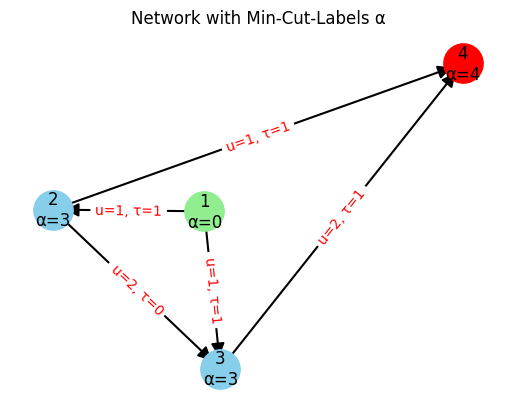

In [4]:
# Create the graph and display the Min-Cut-values
G = create_graph(arcs, capacities, transit_times, alpha=alpha)
visualize_graph(G, sources, sinks)

2. Step: Find all interesting time points 
$$\overset{\sim}{T} = \bigcup_{X\subset S\ :\ X\cap S^+ \neq \emptyset,\ S^-\setminus X \neq \emptyset } \{\alpha_{v,X} : v\in V\}$$

In [5]:
# Compute "interesting" time points, i.e. all time points of cuts over time for different subsets of terminals
time_points = aggregate_cut_time_points(sources, sinks, arcs, capacities, transit_times, time_horizon)
print('\n\nT~ =', time_points)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 9 rows, 12 columns and 23 nonzeros
Model fingerprint: 0xbb41c9b9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 5 rows and 7 columns
Presolve time: 0.01s
Presolved: 4 rows, 5 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.000000e+00   0.000000e+00      0s
       4    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.000000000e+00
Optimal objective value: 4.0
y[(1, 2)] = 2.0
y[(1, 3)] = 2.0
y[(2, 4)] = 0.0
y[(3, 4)] = 0.0
y[(2, 3)] = 0.0
y[('psi', 1)

In [6]:
# Create two dctionaries assigning to each alpha-value (time point) the number of its coresponding time layer and vice versa
alpha_to_index = {time: idx + 1 for idx, time in enumerate(time_points)}
index_to_alpha = dict(enumerate(time_points, start=1))
index_to_alpha

{1: 0, 2: 3, 3: 4}

## Construction of the generalized time-expanded network
- Nodes $V^{\overset{\sim}{T}} = \{v^i : i \in \{1,\ldots,\overset{\sim}{T}\}, v\in V\}$
- "upward" arcs $A_{\infty}$
- arcs $A_{<\infty}$

3. Step: Construction of $A_\infty$

In [7]:
nodes = list(set([node for arc in arcs for node in arc]))
nodes_T_tilde = [f'{node}^{t}' for node, t in itertools.product(nodes, index_to_alpha.keys())]
#print(nodes_T_tilde)
df_inf = create_A_inf(nodes, index_to_alpha)
print('A_inf')
df_inf

A_inf


,v^i,w^j,capacity,length,alpha_v,alpha_w
0,1^1,1^2,10000,1,0,3
1,1^2,1^3,10000,1,3,4
2,2^1,2^2,10000,1,0,3
3,2^2,2^3,10000,1,3,4
4,3^1,3^2,10000,1,0,3
5,3^2,3^3,10000,1,3,4
6,4^1,4^2,10000,1,0,3
7,4^2,4^3,10000,1,3,4


3. Step: Construction of $A_{<\infty}$

In [47]:

def cut_capacity(graph, set_from, set_to):
    """
    Computes the capacity of a cut in a directed graph.

    Parameters:
    graph (networkx.DiGraph): A directed graph where each edge has a 'capacity' attribute.
    set_from (set): Set of nodes on one side of the cut.
    set_to (set): Set of nodes on the other side of the cut.

    Returns:
    int or float: The total capacity of edges crossing from set_s to set_t.
    """
    # Make sure, each node is only contained once in the sets set_from and set_to
    set_from = list(set(set_from))
    set_to = list(set(set_to))
    print('V_i_to_j = ', set_from)
    print('W_i_to_j = ', set_to)
    cut_capacity = 0
    for u in set_from:
        for v in graph.successors(u):
            if v in set_to:
                cut_capacity += graph[u][v].get('capacity', 0)
    print('total cut capacity : ', cut_capacity)
    return int(cut_capacity)

#df = pd.concat([df_inf, df_fin], ignore_index=True)
#G_ext = create_graph_from_df(df, 'v^i', 'w^j', 'capacity', 'length')
#cut_capacity(G_ext, ['1^1', '2^1'], ['3^1', '4^1'])

In [44]:
df_fin = initialize_A_fin(arcs, time_points, capacities, transit_times)
(df_fin[df_fin.length == 1])[df_fin.alpha_w !=4]

C:\Users\flore\AppData\Local\Temp\ipykernel_17528\2707699590.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (df_fin[df_fin.length == 1])[df_fin.alpha_w !=4]


,v^i,w^j,capacity,length,alpha_v,alpha_w,original_capacity,original_transit_time
1,1^1,2^2,0,1,0,3,1,1
7,1^1,3^2,0,1,0,3,1,1
13,2^1,4^2,0,1,0,3,1,1
19,3^1,4^2,0,1,0,3,2,1
25,2^1,3^2,0,1,0,3,2,0


In [64]:
def create_A_fin(arcs, time_points, original_capacities, original_transit_times):

    # initalize the finite-capacty arc set with capacity = 0
    df_fin = initialize_A_fin(arcs, time_points, original_capacities, original_transit_times)

    # Compute time level nr (by splitting the node's name at '^' and taking the latter part)
    df_fin['i'] = [int(s.split('^')[1]) for s in df_fin['v^i']] 
    df_fin['j'] = [int(s.split('^')[1]) for s in df_fin['w^j']] 
    

    # Helper function to calculate the capacity for arcs of length zero
    def calculate_capacity_for_length_zero_arcs(row):
        # Set capacities for arcs of length 0, which do not belong to the top layer
        if (row['length'] == 0) and (row['alpha_v']  < time_horizon):
            # capacity(v^i,w^i) = original_capacity(v,w) * (alpha(i+1) - alpha(i) - transit_time(v,w))
            return max(0, row['original_capacity'] * (index_to_alpha[row['i'] + 1] - row['alpha_v'] - row['original_transit_time']))
        else:
            return row['capacity']  # Or another default value if needed


    # Apply the function row-wise and assign the result to a new column
    df_fin['capacity'] = df_fin.apply(calculate_capacity_for_length_zero_arcs, axis=1) 


    # Compute arc capacites for arc lengths of ell > 0
    # Helper function
    def max_term_for_arcs_of_lenth_at_least_1(row):
        # Access the required alpha values
        alpha_1 = row['alpha_v'] # alpha[i]
        alpha_2 = index_to_alpha[row['i'] + ell + 1] # alpha[i + ell + 1]
        print('alpha[i + ell + 1] : ' )
        
        # Calculate the max term
        max_term = max(0, row['original_capacity'] * (alpha_2 - alpha_1 - row['original_transit_time']))
        
        return max_term

    #df_fin['window_cap'] = None
    for ell in range(1, len(time_points)): # for ell in {1, 2, | T_tilde | - 1}
        # Loop over the arcs of length ell
        if ell == 2:
            break
        df = df_fin[df_fin['length'] == ell]
        for index, row in df.iterrows():
            # Create networkx graph with current capacities
            graph = create_graph_from_df(df_fin, 'v^i', 'w^j', 'capacity', 'length')
            # For arc (v^i, w^j) get the original node names v,w and the indices i,j
            v, i = row['v^i'].split('^') 
            w, j = row['w^j'].split('^') 
            # leave the capacities for arcs inside and into the top layer unchanged
            if (int(j) < len(time_points)) and (int(i) < len(time_points)):
                print('index : ', index, f"\t arc : ({row['v^i']}, {row['w^j']})")
                # Node sets {v^i, v^{i+1}, ..., v^j} and {w^i, w^{i+1}, ..., w^j}
                V_i_to_j = [f'{v}^{k}' for k in range(int(i), int(j)+1)]
                W_i_to_j = [f'{w}^{k}' for k in range(int(i), int(j)+1)]
                # Compute the capacity of the cut separating V_i_to_j and W_i_to_j 
                window_capacity = cut_capacity(graph, V_i_to_j, W_i_to_j)
                # Compute capacity for current arc
                cap = max_term_for_arcs_of_lenth_at_least_1(row) - window_capacity
                df.at[index, 'capacity'] = cap
                df_fin.at[index, 'capacity'] = cap
                #df_fin.at[index, 'window_cap'] = window_capacity
                print(f"new cap of ({row['v^i']}, {row['w^j']}) = ", cap)

    return df_fin
df_fin = create_A_fin(arcs, time_points, capacities, transit_times)
(df_fin[df_fin['length'] == 1])


index :  1 	 arc : (1^1, 2^2)
V_i_to_j =  ['1^1', '1^2']
W_i_to_j =  ['2^1', '2^2']
total cut capacity :  2
alpha[i + ell + 1] : 
new cap of (1^1, 2^2) =  1
index :  7 	 arc : (1^1, 3^2)
V_i_to_j =  ['1^1', '1^2']
W_i_to_j =  ['3^1', '3^2']
total cut capacity :  2
alpha[i + ell + 1] : 
new cap of (1^1, 3^2) =  1
index :  13 	 arc : (2^1, 4^2)
V_i_to_j =  ['2^1', '2^2']
W_i_to_j =  ['4^2', '4^1']
total cut capacity :  2
alpha[i + ell + 1] : 
new cap of (2^1, 4^2) =  1
index :  19 	 arc : (3^1, 4^2)
V_i_to_j =  ['3^1', '3^2']
W_i_to_j =  ['4^2', '4^1']
total cut capacity :  4
alpha[i + ell + 1] : 
new cap of (3^1, 4^2) =  2
index :  25 	 arc : (2^1, 3^2)
V_i_to_j =  ['2^1', '2^2']
W_i_to_j =  ['3^1', '3^2']
total cut capacity :  8
alpha[i + ell + 1] : 
new cap of (2^1, 3^2) =  0


,v^i,w^j,capacity,length,alpha_v,alpha_w,original_capacity,original_transit_time,i,j
1,1^1,2^2,1,1,0,3,1,1,1,2
4,1^2,2^3,0,1,3,4,1,1,2,3
7,1^1,3^2,1,1,0,3,1,1,1,2
10,1^2,3^3,0,1,3,4,1,1,2,3
13,2^1,4^2,1,1,0,3,1,1,1,2
16,2^2,4^3,0,1,3,4,1,1,2,3
19,3^1,4^2,2,1,0,3,2,1,1,2
22,3^2,4^3,0,1,3,4,2,1,2,3
25,2^1,3^2,0,1,0,3,2,0,1,2
28,2^2,3^3,0,1,3,4,2,0,2,3


In [69]:
df_fin = df_fin.drop(df_fin[df_fin['capacity'] == 0].index)
df = pd.concat([df_fin, df_inf])
df[['v^i', 'w^j', 'capacity', 'length', 'alpha_v', 'alpha_w']]

,v^i,w^j,capacity,length,alpha_v,alpha_w
0,1^1,2^1,2,0,0,0
1,1^1,2^2,1,1,0,3
6,1^1,3^1,2,0,0,0
7,1^1,3^2,1,1,0,3
12,2^1,4^1,2,0,0,0
13,2^1,4^2,1,1,0,3
18,3^1,4^1,4,0,0,0
19,3^1,4^2,2,1,0,3
24,2^1,3^1,6,0,0,0
27,2^2,3^2,2,0,3,3


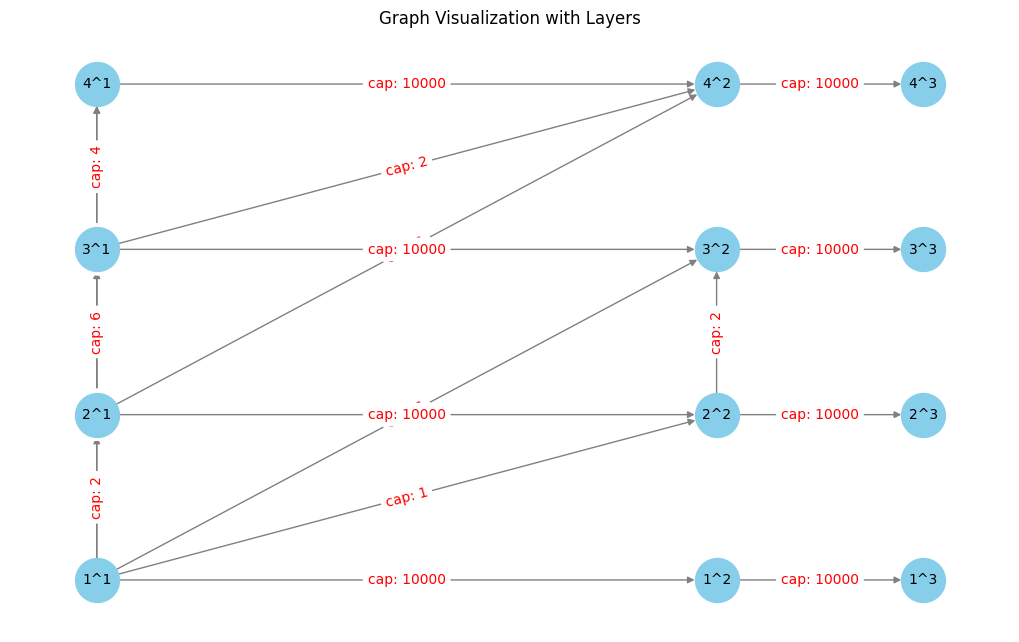

In [72]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph along with attributes
for _, row in df.iterrows():
    G.add_edge(row['v^i'], row['w^j'], capacity=row['capacity'], length=row['length'])

# Set node positions based on layers alpha_v and alpha_w
pos = {}
layer_gap = 5
node_gap = 1

for _, row in df.iterrows():
    v, w = row['v^i'], row['w^j']
    pos[v] = (row['alpha_v'] * layer_gap, int(v.split('^')[0]) * node_gap)
    pos[w] = (row['alpha_w'] * layer_gap, int(w.split('^')[0]) * node_gap)

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(
    G, pos,
    with_labels=True,
    node_color='skyblue',
    node_size=1000,
    edge_color='gray',
    arrows=True,
    font_size=10
)

# Add edge labels (capacity or length)
edge_labels = {(row['v^i'], row['w^j']): f"cap: {row['capacity']}" for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Graph Visualization with Layers")
plt.show()